In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
import copy
from scipy import stats

import multiprocessing
import time
from scipy.sparse import diags
from pymatsolver import Pardiso as Solver


In [22]:
# models = np.load('../rto_models_2d_l1px2py2pz2.npy')
# models = np.load('../rto_models_2d_l0px2py2pz2.npy')
# models = np.load('../rto_models_2d_l2px2py2pz2_200samples.npy')
# models = np.load('../rto_models_2d_l2px2py2pz2_5samples.npy')
# models = np.load('../rto_models_2d_l1px1py1pz1.npy')
# models2 = np.load('../rto_models_2d_l2.npy')
# models = np.load('../hmc_2d_L2p2.npy')

models = np.load('/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/model.npy')

In [23]:
print(models.shape)
results = models

(10, 7021)


In [4]:
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) # + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph])  # + \
    # norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) # + \
    # norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph])


mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

-15.0 15 -15.0 0.0


/tmp/ipykernel_6981/1091913159.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(mtrue_plotting, ax=ax, pcolorOpts={'norm':LogNorm(vmin=clim[0], vmax=clim[1]), 'cmap':"Spectral"})


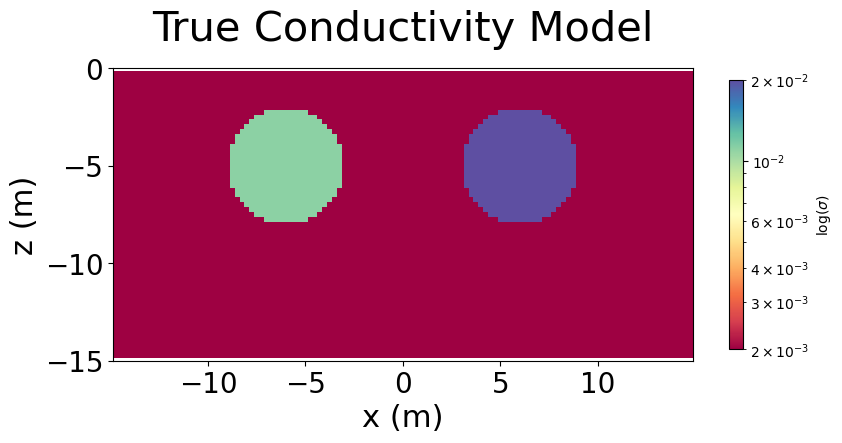

In [106]:
mtrue_plotting = np.exp(mtrue[actcore])
clim = [mtrue_plotting.min(), mtrue_plotting.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue_plotting, ax=ax, pcolorOpts={'norm':LogNorm(vmin=clim[0], vmax=clim[1]), 'cmap':"Spectral"})
ax.set_title('True Conductivity Model',fontsize=30, pad=20)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0], label=r'$\log(\sigma)$', shrink=0.7)
plt.show()

/tmp/ipykernel_623670/4114981224.py:2: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.vstack(results).mean(axis=0), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_623670/4114981224.py:33: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


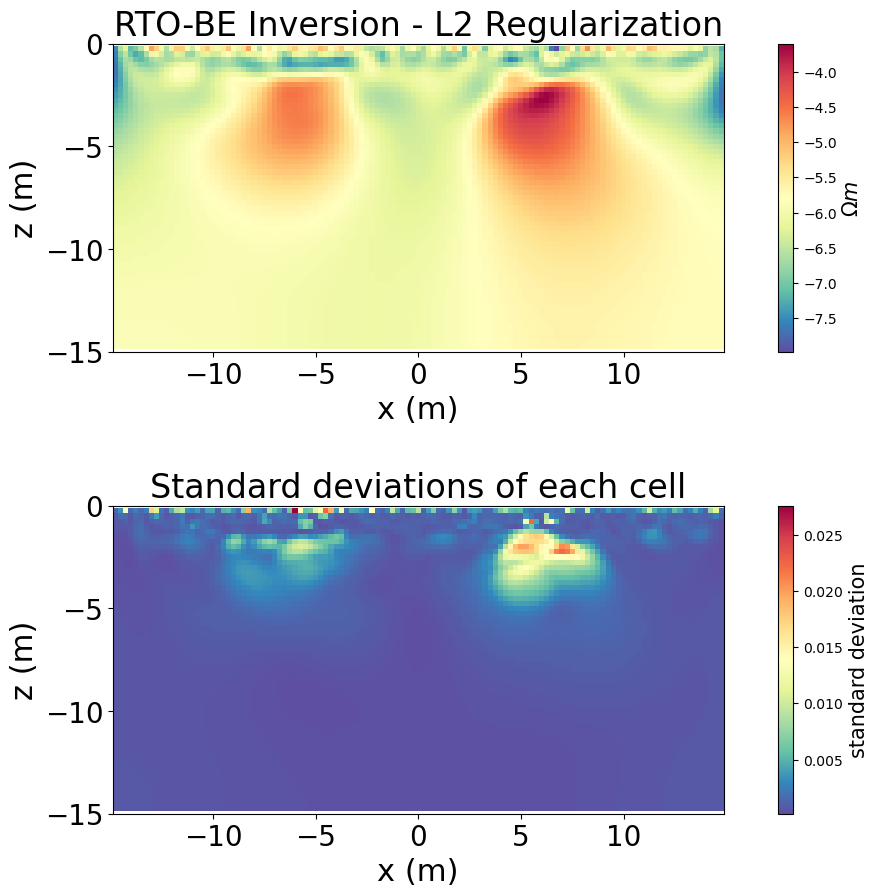

In [25]:


fig, ax = plt.subplots(2,1,figsize=(15,10))
dat = meshCore.plotImage(np.vstack(results).mean(axis=0), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0].set_title('RTO-BE Inversion - L2 Regularization',fontsize=24)
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlabel('x (m)',fontsize=22)
ax[0].set_ylabel('z (m)',fontsize=22)
ax[0].tick_params(labelsize=20)
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')


std_plot_model = np.exp(np.vstack(results).std(axis=0))
percentile_idx = std_plot_model < 0.006
std_plot_model[percentile_idx] = np.nan
# dat2 = meshCore.plotImage(std_plot_model, ax=ax[0], clim=[0, 0.05], pcolorOpts={'cmap':"binary", 'alpha':0.5})

# utils.plot2Ddata(

#     meshCore.gridCC,std_plot_model,nx=500,ny=500,
#     contourOpts={'alpha':0.1, 'cmap':"binary"},
#     #clim=[0,5],
#     ax=ax[0],
#     level=True,
#     ncontour=15,
#     levelOpts={'colors':'k','linewidths':1,'linestyles':'-', 'alpha':0.3},
#     method='nearest'
    
# )

std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
# dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(models2)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.3})
ax[1].set_title('Standard deviations of each cell',fontsize=24)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
plt.colorbar(dat2[0]).set_label(label=r'standard deviation',size=15)

fig.subplots_adjust(right=0.85, hspace=0.5)

plt.show()
# ------------------------------------------------------------------------------------------------

# # generate acquisition data (true data)

# #

# # Setup a Dipole-Dipole Survey with 1m and 2m dipoles
# xmin, xmax = -15., 15.
# ymin, ymax = 0., 0.
# zmin, zmax = 0, 0

# endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
# survey1 = dcutils.generate_dcip_survey(
#     endl, survey_type="dipole-dipole", dim=mesh.dim,
#     a=1, b=1, n=16, d2flag='2.5D'
# )
# survey2 = dcutils.generate_dcip_survey(
#     endl, survey_type="dipole-dipole", dim=mesh.dim,
#     a=2, b=2, n=16, d2flag='2.5D'
# )

# survey = dc.Survey(survey1.source_list + survey2.source_list)

# # Setup Problem with exponential mapping and Active cells only in the core mesh
# expmap = maps.ExpMap(mesh)
# mapactive = maps.InjectActiveCells(
#     mesh=mesh,  indActive=actcore,
#     valInactive=-np.log(1e8)
# )
# mapping = expmap * mapactive
# simulation = dc.Simulation2DNodal(
#     mesh,
#     survey,
#     sigmaMap=mapping,
#     storeJ=True,
#     solver=Solver
# )

# std_sim = 0.02

# simulation_data = simulation.make_synthetic_data(mtrue[actcore], relative_error=std_sim, force=True)
# # survey.eps = 1e-4
# simulation.survey.dobs = simulation_data.dobs

# std = 0.002 * np.abs(simulation.survey.dobs)

# Wd = np.diag(std)

# perturbed_data = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]
# data_object = data.Data(simulation.survey, dobs=perturbed_data, standard_deviation=std)

# dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

(100, 119, 59) (119, 59)


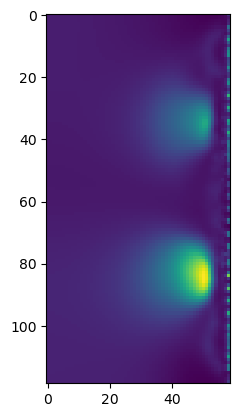

In [219]:
reshape_model = np.exp(results).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
reshaped_draws = np.exp(results).reshape((100, meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
print(reshaped_draws.shape, reshape_model.shape)
reshape_model_std = np.exp(results).std(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
# print(meshCore.cell_centers_y)

plt.imshow(reshape_model)
plt.show()

# plt.plot(meshCore.cell_centers_y, reshape_model[83, :], '.-')

(500, 7021)


/tmp/ipykernel_6981/718981762.py:13: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


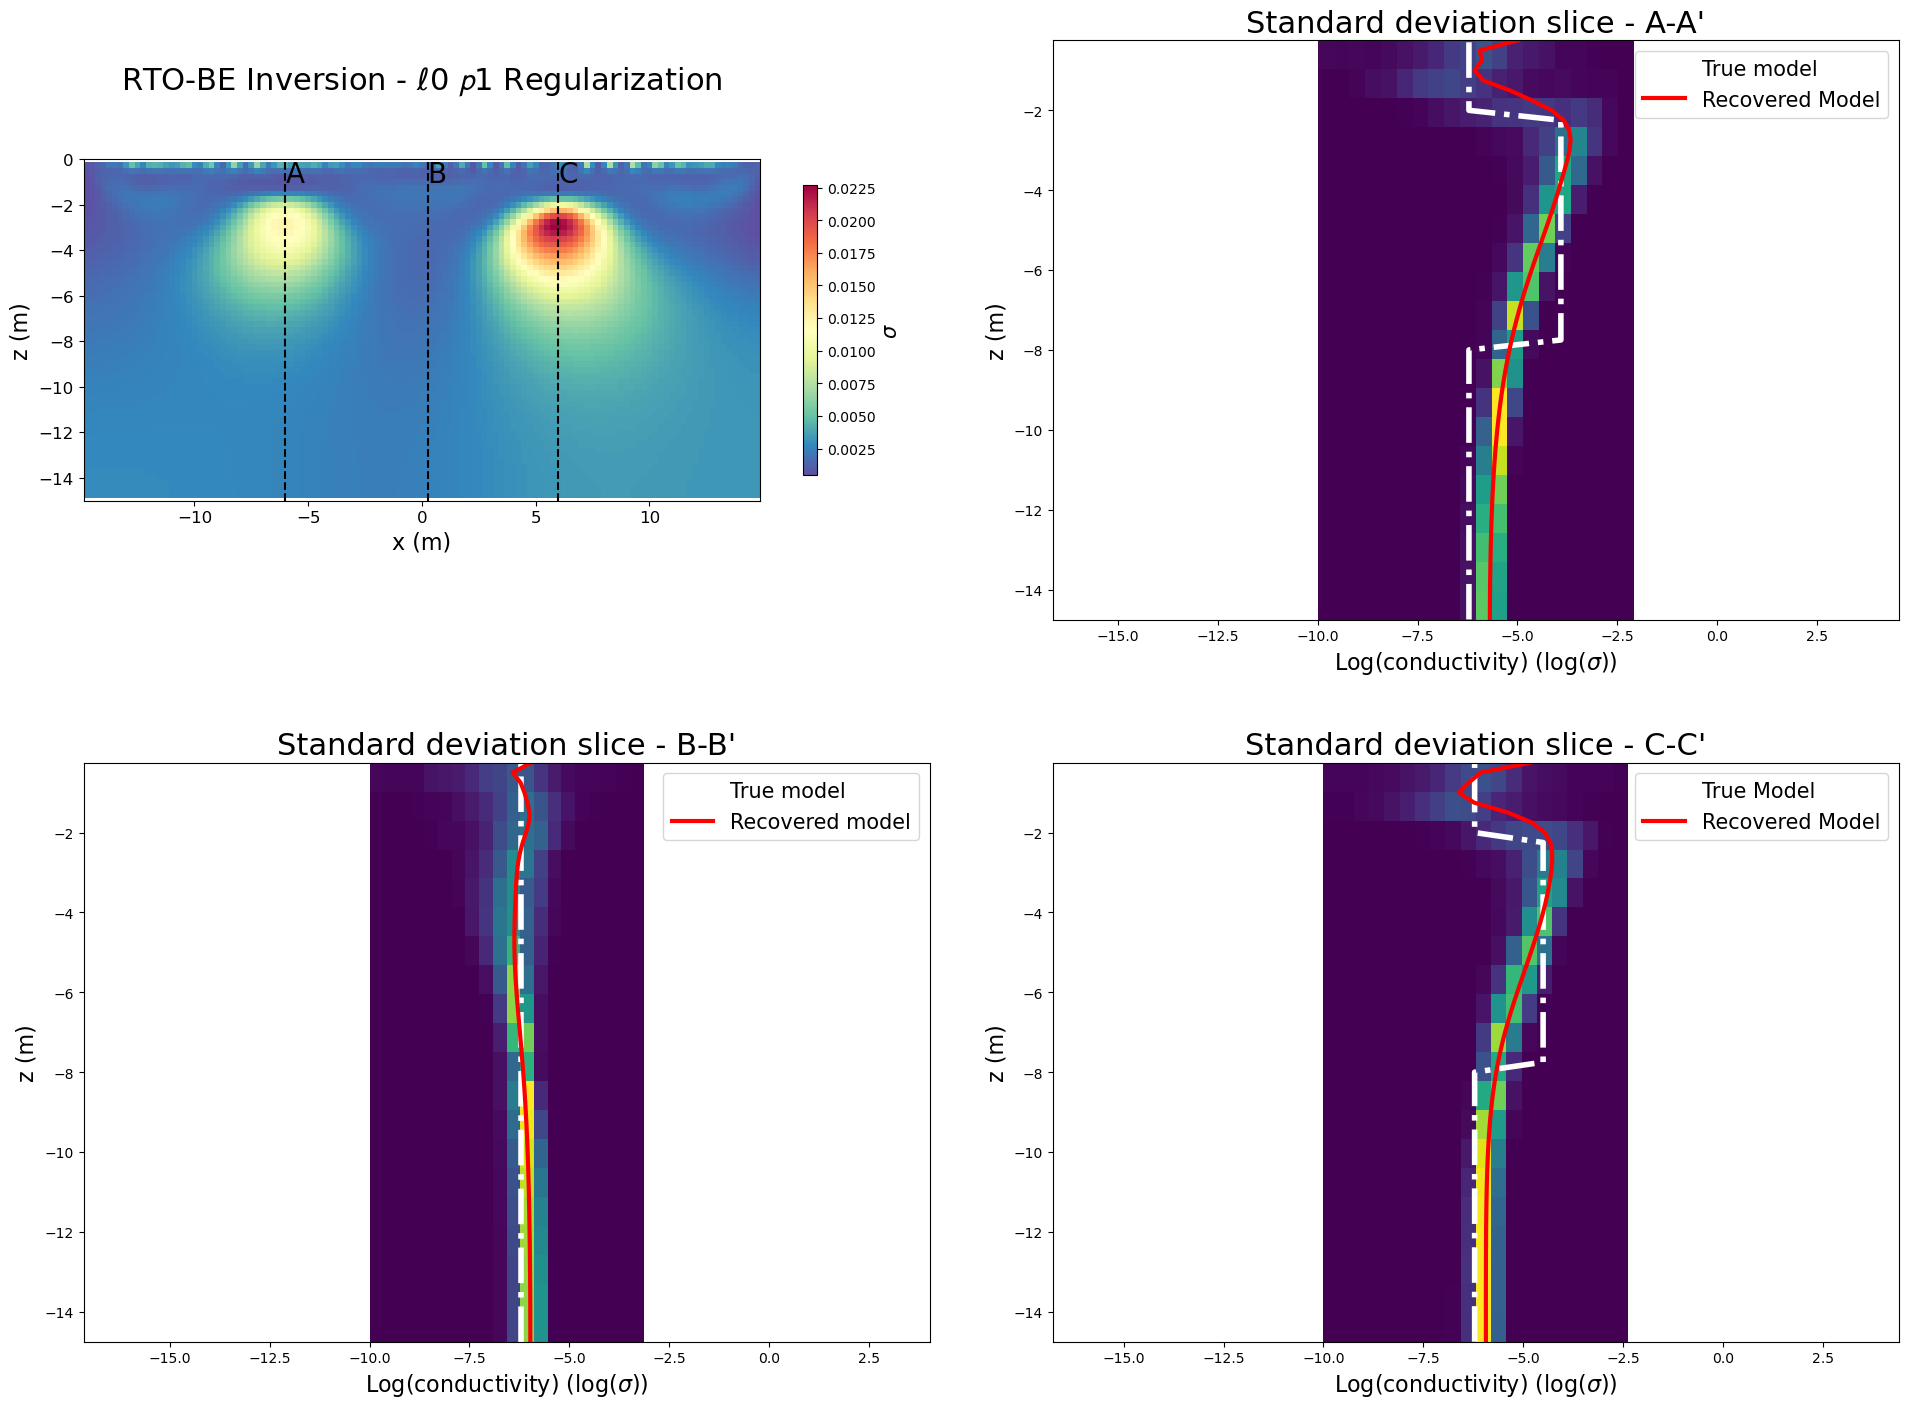

In [111]:
results = np.load('/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l0p1_500samples.npy')
reshape_model = np.exp(results).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
reshaped_draws = np.exp(results).reshape((500, meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20,15))
title = r'RTO-BE Inversion - $\ell$0 $\mathcal{p}$1 Regularization'
# plt.rcParams['axes.titlepad'] = 14
print(results.shape)

x_line0 = 83
x_line = 60
x_line1 = 35

dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0, 0].set_title(title,fontsize=22, pad=50)
ax[0, 0].set_aspect('equal')
ax[0, 0].set_ylim([-15,0])
ax[0, 0].set_xlabel('x (m)',fontsize=16)
ax[0, 0].set_ylabel('z (m)',fontsize=16)
ax[0, 0].tick_params(labelsize=12)
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line0], color = 'k', label = 'axvline - full height', linestyle="--")
ax[0, 0].text(meshCore.cell_centers_x[x_line1],-1,'A', fontsize=20)
# ax[0, 0].text(meshCore.cell_centers_x[x_line1],-14.5,"A'", fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line],-1,'B', fontsize=20)
# ax[0, 0].text(meshCore.cell_centers_x[x_line],-14.5,"B'", fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line0],-1,'C', fontsize=20)
# ax[0, 0].text(meshCore.cell_centers_x[x_line0],-14.5,"C'", fontsize=20)
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line], color = 'k', label = 'axvline - full height', linestyle="--")
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line1], color = 'k', label = 'axvline - full height', linestyle="--")
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0], shrink=0.5).set_label(label=r'$\sigma$',size=15,weight='bold')
# print(np.array(reshaped_draws[:, 83, :]).reshape(-1).shape, np.tile(mesh.cell_centers_y, 5).shape, reshaped_draws[:, 83, :].mean(axis=0).shape, meshCore.cell_centers_y.shape)
ax[0, 1].hist2d(np.log(np.array(reshaped_draws[:, x_line0, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 500),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[0, 1].plot(mtrue_reshaped[x_line0, :], meshCore.cell_centers_y, '-.w', linewidth=4.0, label='True model')
ax[0, 1].plot(np.log(reshape_model[x_line0, :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Recovered Model')
ax[0, 1].set_ylabel('z (m)',fontsize=16)
ax[0, 1].set_xlabel(r'Log(conductivity) (log($\sigma$))',fontsize=16)
ax[0, 1].axis('equal')
ax[0, 1].set_title("Standard deviation slice - A-A'", fontsize=22)
ax[0, 1].legend(fontsize = 15)


ax[1, 0].hist2d(np.log(np.array(reshaped_draws[:, x_line, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 500),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[1, 0].plot(mtrue_reshaped[x_line, :], meshCore.cell_centers_y, '-.w', linewidth=4.0,  label='True model')
ax[1, 0].plot(np.log(reshape_model[x_line, :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Recovered model')
ax[1, 0].set_ylabel('z (m)',fontsize=16)
ax[1, 0].set_xlabel(r'Log(conductivity) (log($\sigma$))',fontsize=16)
ax[1, 0].axis('equal')
ax[1, 0].set_title("Standard deviation slice - B-B'", fontsize=22)
ax[1, 0].legend(fontsize = 15)

ax[1, 1].hist2d(np.log(np.array(reshaped_draws[:, x_line1, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 500),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[1, 1].plot(mtrue_reshaped[x_line1, :], meshCore.cell_centers_y, '-.w', linewidth=4.0, label='True Model')
ax[1, 1].plot(np.log(reshape_model[x_line1, :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Recovered Model')
ax[1, 1].set_ylabel('z (m)',fontsize=16)
ax[1, 1].set_xlabel(r'Log(conductivity) (log($\sigma$))',fontsize=16)
ax[1, 1].axis('equal')
ax[1, 1].set_title("Standard deviation slice - C-C'", fontsize=22)
ax[1, 1].legend(fontsize = 15)

fig.tight_layout(pad=4.0)


(100, 119, 59) (119, 59)


/tmp/ipykernel_452811/4148211799.py:14: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})


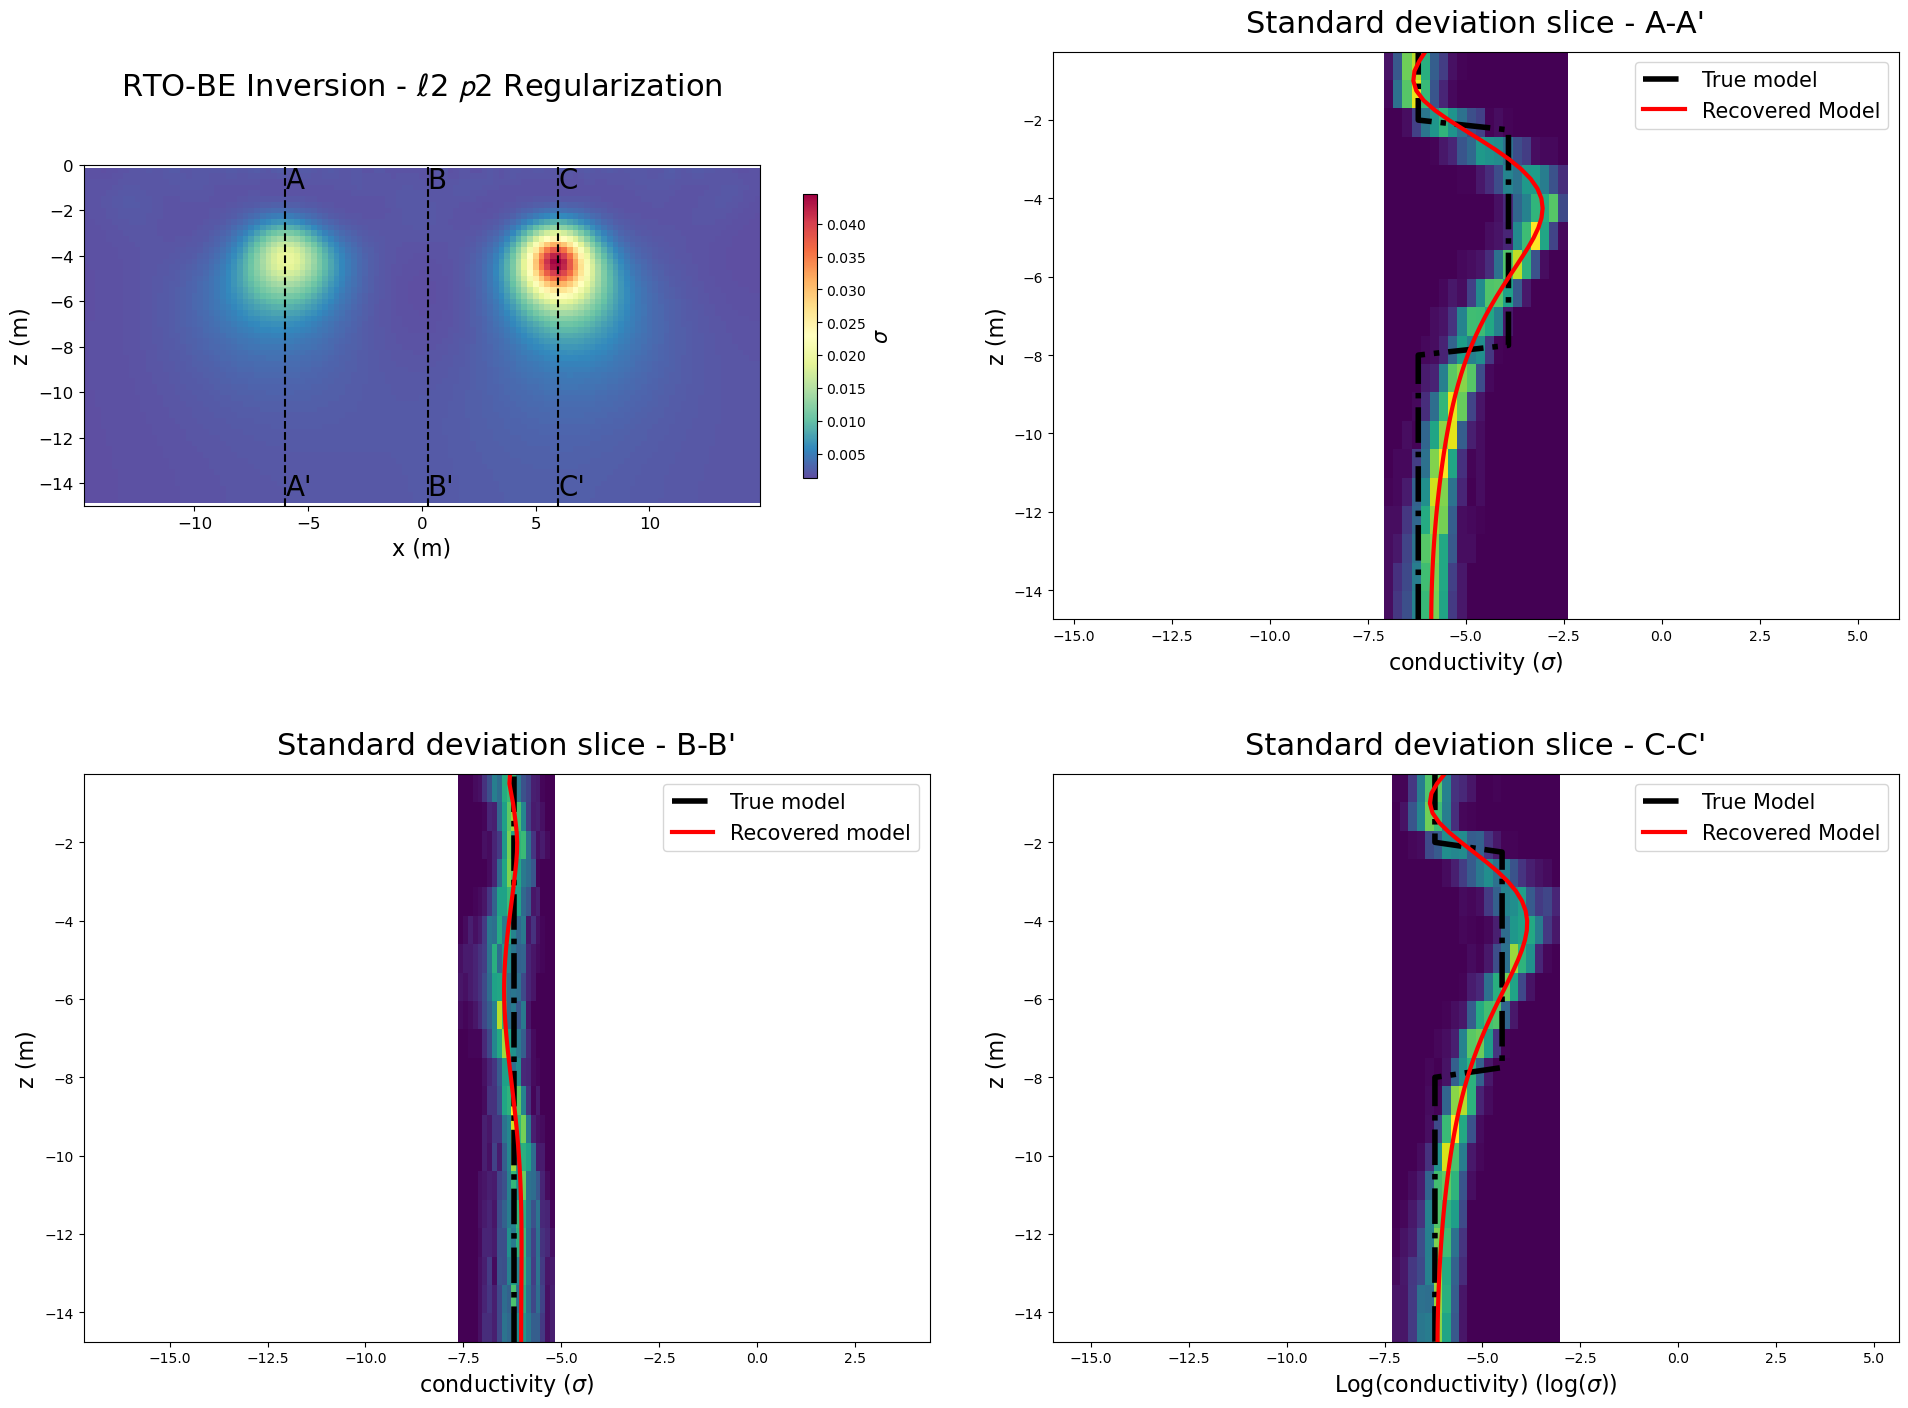

In [284]:
results = np.load('/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l2p2_100samples.npy')
reshape_model = np.exp(results).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
reshaped_draws = np.exp(results).reshape((100, meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
print(reshaped_draws.shape, reshape_model.shape)
reshape_model_std = np.exp(results).std(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20,15))
title = r'RTO-BE Inversion - $\ell$2 $\mathcal{p}$2 Regularization'
# plt.rcParams['axes.titlepad'] = 14

x_line0 = 83
x_line = 60
x_line1 = 35

dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0, 0].set_title(title,fontsize=22, pad=50)
ax[0, 0].set_aspect('equal')
ax[0, 0].set_ylim([-15,0])
ax[0, 0].set_xlabel('x (m)',fontsize=16)
ax[0, 0].set_ylabel('z (m)',fontsize=16)
ax[0, 0].tick_params(labelsize=12)
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line0], color = 'k', label = 'axvline - full height', linestyle="--")
ax[0, 0].text(meshCore.cell_centers_x[x_line1],-1,'A', fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line1],-14.5,"A'", fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line],-1,'B', fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line],-14.5,"B'", fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line0],-1,'C', fontsize=20)
ax[0, 0].text(meshCore.cell_centers_x[x_line0],-14.5,"C'", fontsize=20)
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line], color = 'k', label = 'axvline - full height', linestyle="--")
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line1], color = 'k', label = 'axvline - full height', linestyle="--")
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0], shrink=0.5).set_label(label=r'$\sigma$',size=15,weight='bold')
# print(np.array(reshaped_draws[:, 83, :]).reshape(-1).shape, np.tile(mesh.cell_centers_y, 5).shape, reshaped_draws[:, 83, :].mean(axis=0).shape, meshCore.cell_centers_y.shape)
ax[0, 1].hist2d(np.log(np.array(reshaped_draws[:, x_line0, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[0, 1].plot(mtrue_reshaped[x_line0, :], meshCore.cell_centers_y, '-.k', linewidth=4.0, label='True model')
ax[0, 1].plot(np.log(reshape_model[x_line0, :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Recovered Model')
ax[0, 1].set_ylabel('z (m)',fontsize=16)
ax[0, 1].set_xlabel(r'conductivity ($\sigma$)',fontsize=16)
ax[0, 1].axis('equal')
ax[0, 1].set_title("Standard deviation slice - A-A'", fontsize=22)
ax[0, 1].legend(fontsize = 15)


ax[1, 0].hist2d(np.log(np.array(reshaped_draws[:, x_line, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[1, 0].plot(mtrue_reshaped[x_line, :], meshCore.cell_centers_y, '-.k', linewidth=4.0,  label='True model')
ax[1, 0].plot(np.log(reshape_model[x_line, :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Recovered model')
ax[1, 0].set_ylabel('z (m)',fontsize=16)
ax[1, 0].set_xlabel(r'conductivity ($\sigma$)',fontsize=16)
ax[1, 0].axis('equal')
ax[1, 0].set_title("Standard deviation slice - B-B'", fontsize=22)
ax[1, 0].legend(fontsize = 15)

ax[1, 1].hist2d(np.log(np.array(reshaped_draws[:, x_line1, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[1, 1].plot(mtrue_reshaped[x_line1, :], meshCore.cell_centers_y, '-.k', linewidth=4.0, label='True Model')
ax[1, 1].plot(np.log(reshape_model[x_line1, :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Recovered Model')
ax[1, 1].set_ylabel('z (m)',fontsize=16)
ax[1, 1].set_xlabel(r'Log(conductivity) (log($\sigma$))',fontsize=16)
ax[1, 1].axis('equal')
ax[1, 1].set_title("Standard deviation slice - C-C'", fontsize=22)
ax[1, 1].legend(fontsize = 15)

fig.tight_layout(pad=4.0)


/tmp/ipykernel_6981/382347802.py:40: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(
/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


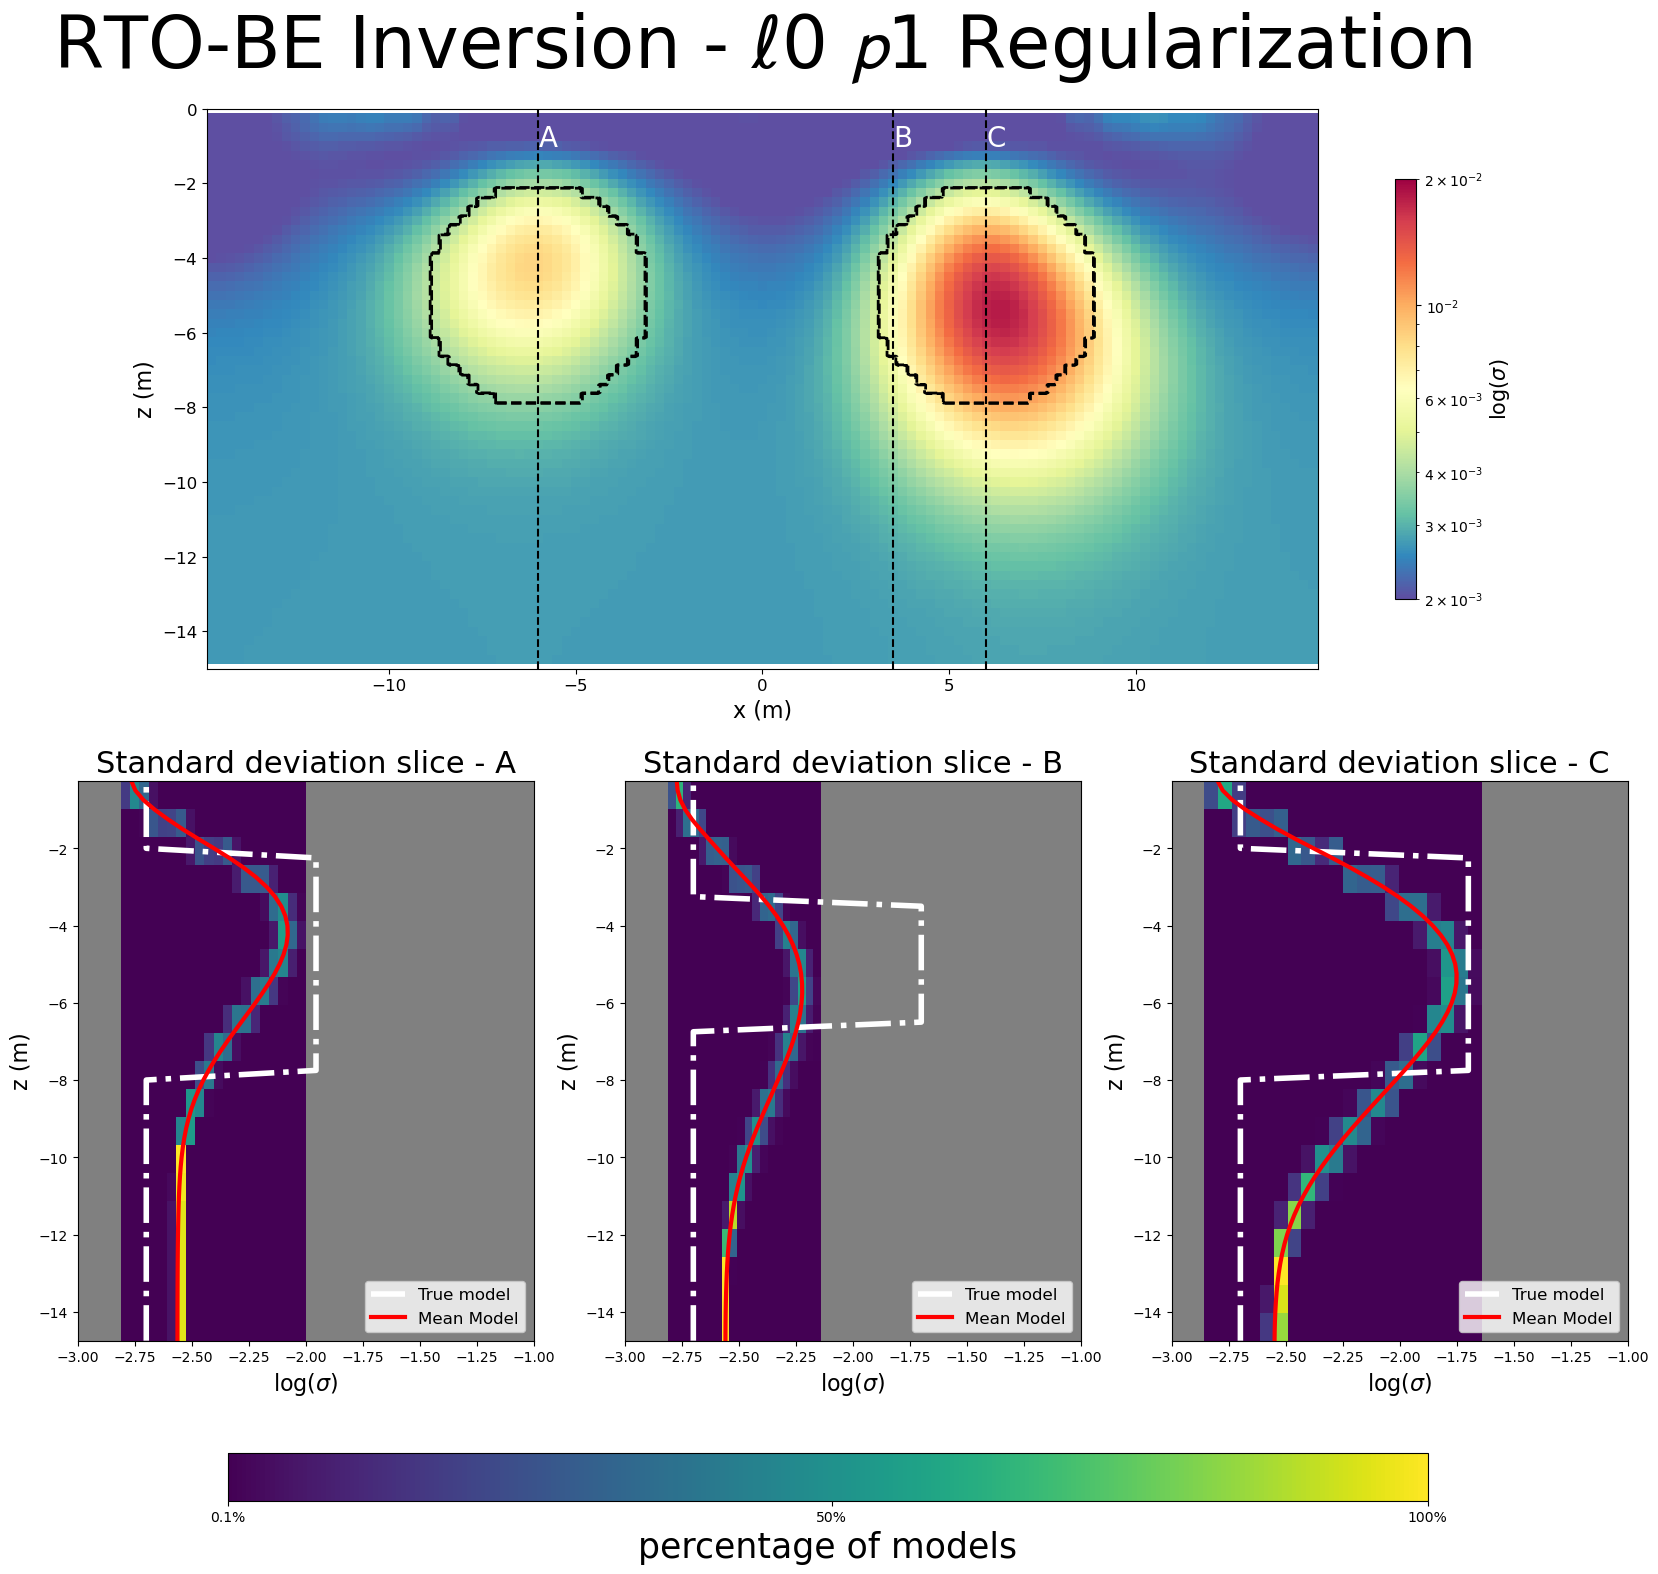

In [211]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import numpy as np

l = 0
p = 1
results = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples_irls.npy')
# results = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l0p0_100samples_sdw_threshold1e-4.npy')
# results = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples.npy')
reshape_model = np.exp(results).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
reshaped_draws = np.exp(results).reshape((100, meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')

# Data for plotting
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and GridSpec for subplots
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

reg_title_1 = r"$\ell$"
reg_title_2 = r"$\mathcal{p}$"

title = f'RTO-BE Inversion - {reg_title_1}{l} {reg_title_2}{p} Regularization'
# plt.rcParams['axes.titlepad'] = 14

x_line0 = 83
x_line = 73
x_line1 = 35

xline = [x_line1, x_line, x_line0]
xline_label= [ 'A', 'B', 'C']

# clim = [np.log(1/500), np.log(1/50)]

ax_main = plt.subplot(gs[0, :])
clim = [1/500, 1/50]
Z = np.vstack(results).mean(axis=0)
dat = meshCore.plotImage(
    np.exp(np.vstack(results).mean(axis=0)), 
    ax=ax_main, 
    # clim=clim, 
    pcolorOpts={"norm":LogNorm(vmin=1/500, vmax=1/50), 'cmap':"Spectral_r"}
)

utils.plot2Ddata(
    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax_main,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
)

# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax_main.set_title(title,fontsize=52, pad=30)
ax_main.set_aspect('equal')
ax_main.set_ylim([-15,0])
ax_main.set_xlabel('x (m)',fontsize=16)
ax_main.set_ylabel('z (m)',fontsize=16)
ax_main.tick_params(labelsize=12)
ax_main.axvline(x = meshCore.cell_centers_x[x_line0], color = 'k', label = 'axvline - full height', linestyle="--")
ax_main.text(meshCore.cell_centers_x[x_line1],-1,'A', fontsize=20, color='white')

ax_main.text(meshCore.cell_centers_x[x_line],-1,'B', fontsize=20, color='white')

ax_main.text(meshCore.cell_centers_x[x_line0],-1,'C', fontsize=20, color='white')

ax_main.axvline(x = meshCore.cell_centers_x[x_line], color = 'k', label = 'axvline - full height', linestyle="--")
ax_main.axvline(x = meshCore.cell_centers_x[x_line1], color = 'k', label = 'axvline - full height', linestyle="--")
plt.colorbar(dat[0], shrink=0.75).set_label(label=r'$\log(\sigma)$',size=15,weight='bold')

# # Create a subplot that spans all 3 columns in the first row
# ax_main = plt.subplot(gs[0, :])
# ax_main.plot(x, y, 'r')  # Example plot, replace with your data
# ax_main.set_title('Top Row - Spans 3 Columns')
# ax_main.set_xlabel('X-axis')
# ax_main.set_ylabel('Y-axis')

# Subplots in the second row
for i in range(3):
    ax = plt.subplot(gs[1, i])
    ax.set_facecolor('grey')
    im = ax.hist2d(np.log10(np.array(reshaped_draws[:, xline[i], :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
    mtrue_reshaped = np.exp(mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F'))
    ax.plot(np.log10(mtrue_reshaped[xline[i], :]), meshCore.cell_centers_y, '-.w', linewidth=4.0, label='True model')
    ax.plot(np.log10(reshape_model[xline[i], :]), meshCore.cell_centers_y, '-r', linewidth=3.0, label='Mean Model')
    ax.set_ylabel('z (m)',fontsize=16)
    ax.set_xlabel(r'$\log(\sigma)$',fontsize=16)
    ax.set_xlim([-3, -1])
    # ax.axis('equal')
    ax.set_title(f"Standard deviation slice - {xline_label[i]}", fontsize=22)
    ax.legend(fontsize=12, loc='lower right')

cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.03])  # [left, bottom, width, height]
# cbar_ax.set_ticks([0, 0.5, 1])  # Define custom ticks
# cbar_ax.set_ticklabels(['Low', 'Medium', 'High'])
cbar = fig.colorbar(im[3], cax=cbar_ax, orientation='horizontal', shrink=0.5)
# cbar.set_ticks([0, 48, 95])  # Define custom ticks
cbar.set_ticks([0, 150, 298])  # Define custom ticks
cbar.set_ticklabels(['0.1%', '50%', '100%']) 
cbar.set_label(label=r'percentage of models',size=25)
# fig.savefig('/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/report/figures/rto_be_dc_shperes_uq_l0p0_100samples.png', dpi=3000)
# Show or save the plot
# plt.show()

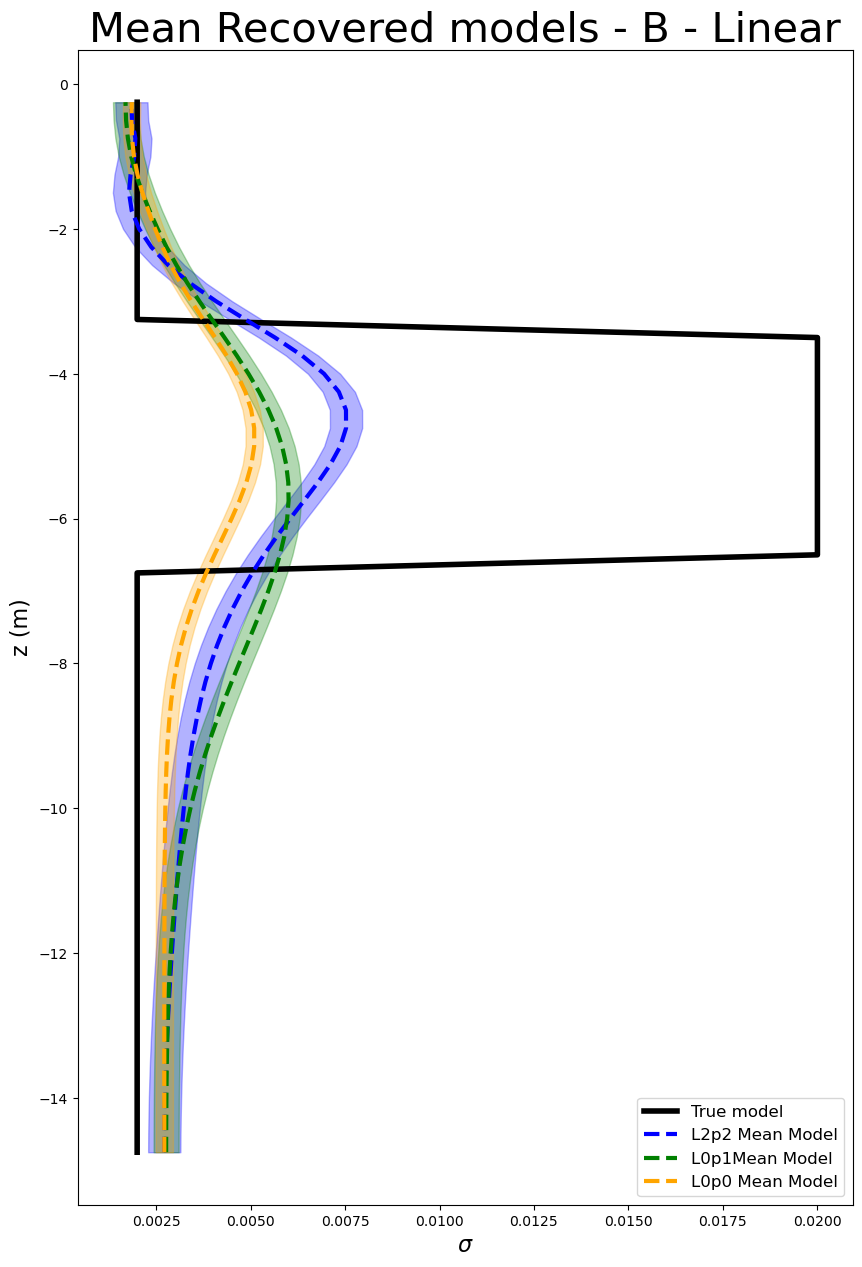

In [128]:
i = 1

# plot true model
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
# im = ax.hist2d(np.log(np.array(reshaped_draws[:, xline[i], :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax.plot(np.exp(mtrue_reshaped[xline[i], :]), meshCore.cell_centers_y, '-k', linewidth=4.0, label='True model')

# plot the recovered models
# l2
l = 2
p = 2
results3 = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples.npy')
reshape_model3 = np.exp(results3).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')

ax.plot(reshape_model3[xline[i], :], meshCore.cell_centers_y, '--b', linewidth=3.0, label='L2p2 Mean Model')
y = reshape_model3[xline[i], :]
ci = []
for ii in range(reshape_model3[xline[i], :].shape[0]):
    ci.append(1.96 * np.std(reshape_model3[xline[i], :])/np.sqrt(reshape_model3[xline[i], :].shape[0]))

ax.fill_betweenx(meshCore.cell_centers_y, (y-ci), (y+ci), color='b', alpha=.3)

# l0 p1
l = 0
p = 1
results = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples_irls.npy')
reshape_model = np.exp(results).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')

ax.plot(reshape_model[xline[i], :], meshCore.cell_centers_y, '--g', linewidth=3.0, label=f'L{l}p{p}Mean Model')
y = reshape_model[xline[i], :]
ci = []
for ii in range(reshape_model[xline[i], :].shape[0]):
    ci.append(1.96 * np.std(reshape_model[xline[i], :])/np.sqrt(reshape_model[xline[i], :].shape[0]))

ax.fill_betweenx(meshCore.cell_centers_y, (y-ci), (y+ci), color='g', alpha=.3)



l = 1
p = 2
results2 = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples.npy')
reshape_model2 = np.exp(results2).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')

l = 0
p = 0
results4 = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples.npy')
reshape_model4 = np.exp(results4).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
l = 0
p = 0
results5 = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples_sdw.npy')
reshape_model5 = np.exp(results5).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')

l = 0
p = 0
# results6 = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l0p0_100samples_sdw_threshold1e-4.npy')
results6 = np.load(f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l{l}p{p}_100samples_irls.npy')
reshape_model6 = np.exp(results6).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')

ax.plot(reshape_model6[xline[i], :], meshCore.cell_centers_y, linestyle='--', color='orange', linewidth=3.0, label=f'L{l}p{p} Mean Model')
y = reshape_model6[xline[i], :]
ci = []
for ii in range(reshape_model4[xline[i], :].shape[0]):
    ci.append(1.96 * np.std(reshape_model6[xline[i], :])/np.sqrt(reshape_model6[xline[i], :].shape[0]))

ax.fill_betweenx(meshCore.cell_centers_y, (y-ci), (y+ci), color='orange', alpha=.3)







# av.fill_between(np.arange(100), (y2-ci2), (y2+ci2), color='g', alpha=.3)
# ax.plot(np.log(reshape_model2[xline[i], :]), meshCore.cell_centers_y, '--g', linewidth=3.0, label='L1p2 Mean Model')


# ax.plot(reshape_model4[xline[i], :], meshCore.cell_centers_y, '--m', linewidth=3.0, label='L0p0 Mean Model')
# y = reshape_model4[xline[i], :]
# ci = []
# for ii in range(reshape_model4[xline[i], :].shape[0]):
#     ci.append(1.96 * np.std(reshape_model4[xline[i], :])/np.sqrt(reshape_model4[xline[i], :].shape[0]))

# ax.fill_betweenx(meshCore.cell_centers_y, (y-ci), (y+ci), color='m', alpha=.3)


# ax.plot(reshape_model5[xline[i], :], meshCore.cell_centers_y, '--c', linewidth=3.0, label='L0p0 Mean Model SDW')

ax.set_ylabel('z (m)',fontsize=16)
ax.set_xlabel(r'$\sigma$',fontsize=16)
# ax.axis('equal')
# ax.set_xlim([0, 1/50])
# ax.set_xscale('log')
ax.set_title(f"Mean Recovered models - {xline_label[i]} - Linear", fontsize=30)
ax.legend(fontsize=12, loc='lower right')

plt.show()


# OK now lets do the beta curves


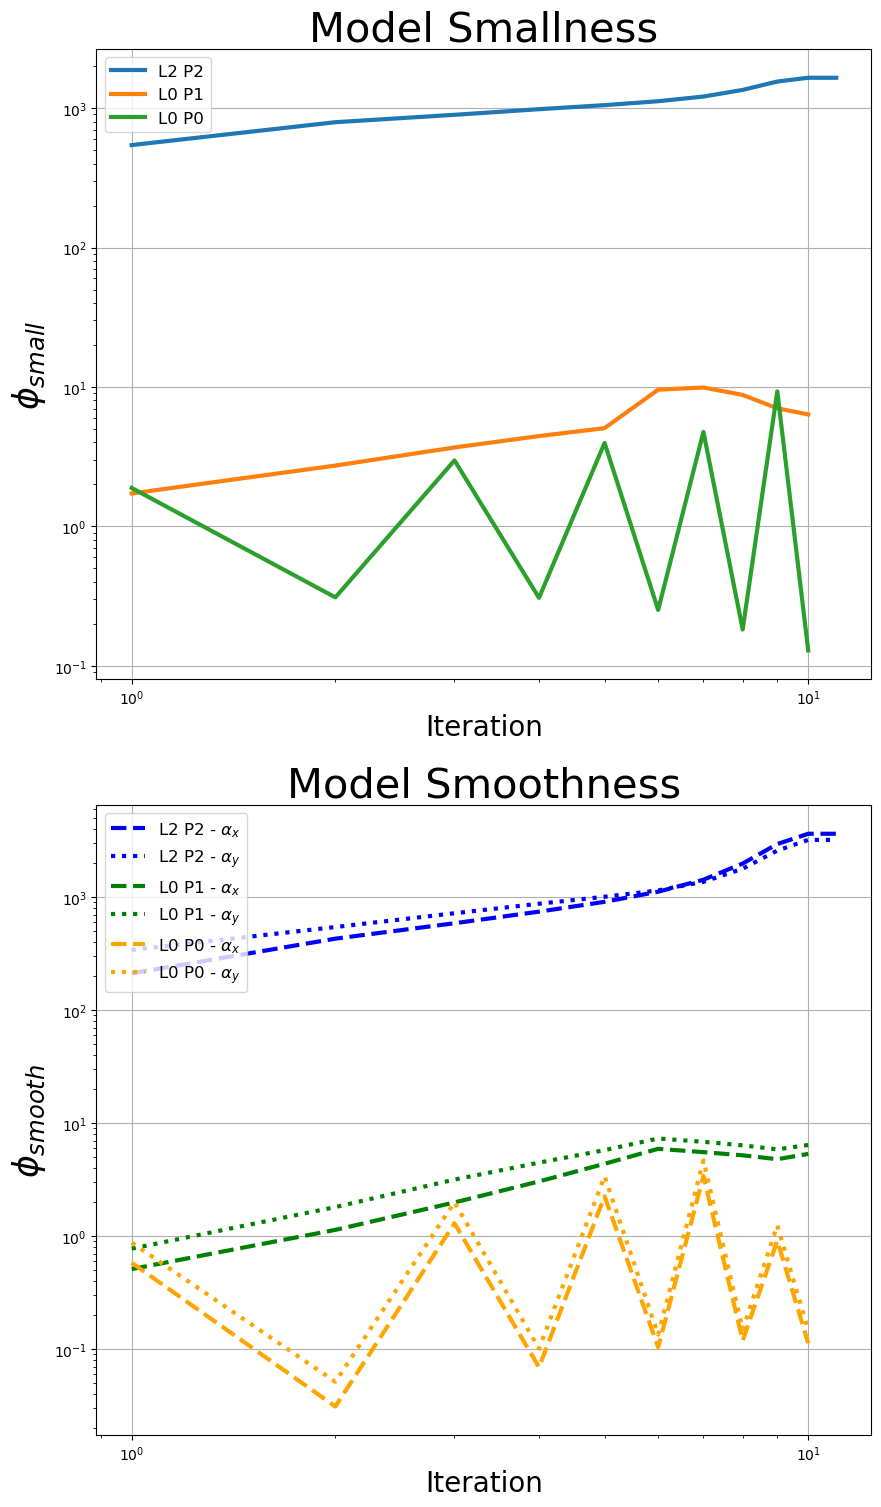

In [209]:
import pandas as pd
phi_s_l2 = [5.43e2, 7.92e2, 8.95e2, 9.82e2, 1.05e3, 1.12e3, 1.21e3, 1.35e3, 1.55e3, 1.65e3, 1.65e3]
phi_x_l2 = [2.12e2, 4.30e2, 5.89e2, 7.46e2, 9.11e2, 1.12e3, 1.43e3, 1.99e3, 2.96e3, 3.65e3, 3.65e3]
phi_y_l2 = [3.42e2, 5.45e2, 7.22e2, 8.77e2, 1.01e3, 1.15e3, 1.37e3, 1.79e3, 2.59e3, 3.22e3, 3.22e3]

# load data into panadas then to xarray dataframe
alphas_file = f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/InversionModel-2023-12-03-14-03-l0p1.txt'
data_obj = pd.read_table(alphas_file, sep='\s+').to_xarray()

phi_s_l0p1 = data_obj['phi_m_small'][:]
phi_x_l0p1 = data_obj['phi_m_smoomth_x'][:][:10]
phi_y_l0p1 = data_obj['phi_m_smoomth_y'][:][:10]

alphas_file = f'/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/InversionModel-2023-12-02-23-59-l0p0.txt'
data_obj = pd.read_table(alphas_file, sep='\s+').to_xarray()

phi_s_l0p0 = data_obj['phi_m_small'][:][:10]
phi_x_l0p0 = data_obj['phi_m_smoomth_x'][:][:10]
phi_y_l0p0 = data_obj['phi_m_smoomth_y'][:][:10]

fig, ax = plt.subplots(2, 1, figsize=(10, 18))
ax[0].loglog(np.arange(1, 12), phi_s_l2, label='L2 P2', linewidth=3.0)
# ax.loglog(np.arange(1, 12), phi_s_l2, label='L2P2')
ax[0].loglog(np.arange(1, 11), phi_s_l0p1, label='L0 P1', linewidth=3.0)
ax[0].loglog(np.arange(1, 11), phi_s_l0p0, label='L0 P0', linewidth=3.0)
ax[0].set_title(r'Model Smallness', size=30)
ax[0].set_xlabel('Iteration', size=20)
ax[0].set_ylabel(r'$\phi_{small}$', size=25)
ax[0].legend(fontsize=12, loc='upper left')
ax[0].grid(True)

ax[1].loglog(np.arange(1, 12), phi_x_l2, '--b', label=r'L2 P2 - $\alpha_x$', linewidth=3.0)
ax[1].loglog(np.arange(1, 12), phi_y_l2, ':b', label=r'L2 P2 - $\alpha_y$', linewidth=3.0)
ax[1].loglog(np.arange(1, 11), phi_x_l0p1, '--g', label=r'L0 P1 - $\alpha_x$', linewidth=3.0)
ax[1].loglog(np.arange(1, 11), phi_y_l0p1, ':g', label=r'L0 P1 - $\alpha_y$', linewidth=3.0)
ax[1].loglog(np.arange(1, 11), phi_x_l0p0, linestyle='--', color='orange', label=r'L0 P0 - $\alpha_x$', linewidth=3.0)
ax[1].loglog(np.arange(1, 11), phi_y_l0p0, linestyle=':', color='orange', label=r'L0 P0 - $\alpha_y$', linewidth=3.0)
ax[1].set_title(r'Model Smoothness', size=30)
ax[1].set_xlabel('Iteration', size=20)
ax[1].set_ylabel(r'$\phi_{smooth}$', size=25)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].grid(True)

In [186]:
data_obj

<xarray.Dataset>
Dimensions:          (index: 10)
Coordinates:
  * index            (index) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    #                (index) int64 1 2 3 4 5 6 7 8 9 10
    beta             (index) float64 267.9 134.0 66.98 ... 21.89 33.52 27.93
    phi_d            (index) float64 1.504e+03 955.2 626.3 ... 408.1 473.5 442.3
    phi_m            (index) float64 3.008 5.675 8.835 ... 20.33 17.69 18.1
    phi_m_small      (index) float64 1.724 2.732 3.683 ... 8.773 7.032 6.354
    phi_m_smoomth_x  (index) float64 0.5105 1.135 1.986 ... 5.193 4.799 5.343
    phi_m_smoomth_y  (index) float64 0.774 1.807 3.166 ... 6.361 5.862 6.406
    phi_m_smoomth_z  (index) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    phi              (index) float64 6.397e+03 1.907e+03 ... 1.091e+03 956.0

/tmp/ipykernel_452811/154856656.py:8: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_452811/154856656.py:39: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


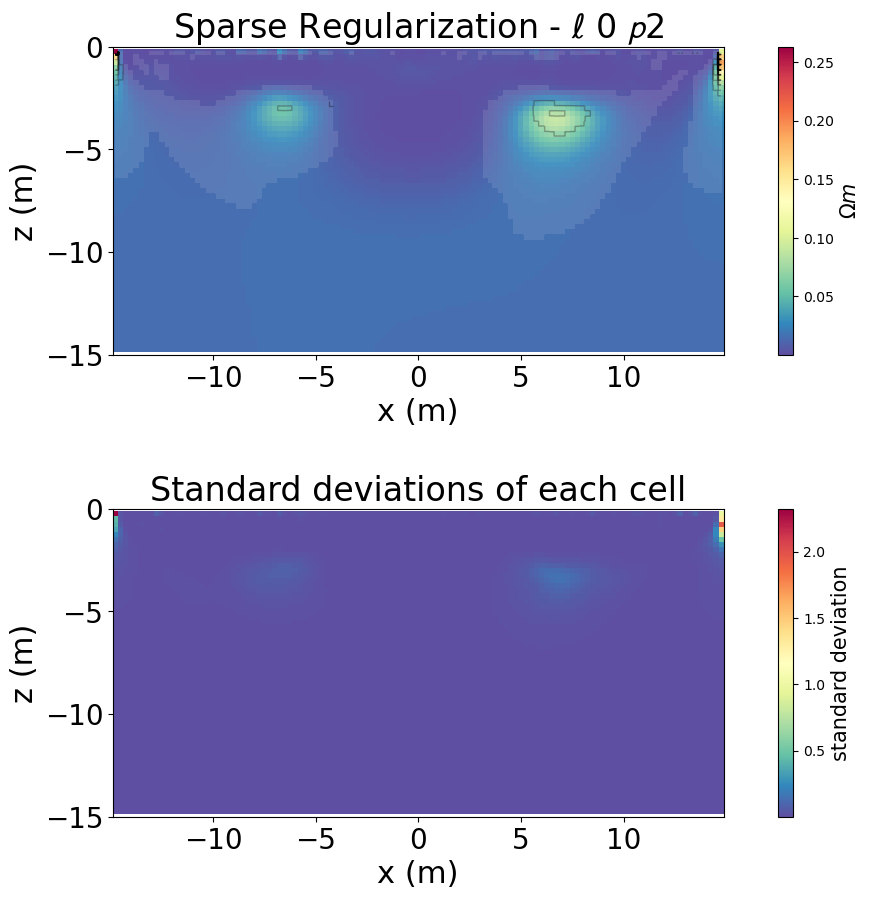

/home/johnathan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/johnathan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


In [64]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
results = np.load('../rto_models_2d_l0px2py2pz2.npy')
# results = np.load('../rto_models_2d_l2-sparse.npy')
# norm_title = r'Sparse Regularization - $\ell$ 1 $\mathcal{p}$2'
norm_title = r'Sparse Regularization - $\ell$ 0 $\mathcal{p}$2'
# norm_title = r'Sparse Regularization - $\ell$ 0 $\mathcal{p}$1'

fig, ax = plt.subplots(2,1,figsize=(15,10))
dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0].set_title(norm_title,fontsize=24)
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlabel('x (m)',fontsize=22)
ax[0].set_ylabel('z (m)',fontsize=22)
ax[0].tick_params(labelsize=20)
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')


std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
percentile_idx = std_plot_model < 0.006
std_plot_model[percentile_idx] = np.nan
# dat2 = meshCore.plotImage(std_plot_model, ax=ax[0], clim=[0, 0.05], pcolorOpts={'cmap':"binary", 'alpha':0.5})

utils.plot2Ddata(

    meshCore.gridCC,std_plot_model,nx=500,ny=500,
    contourOpts={'alpha':0.1, 'cmap':"binary"},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=35,
    levelOpts={'colors':'k','linewidths':1,'linestyles':'-', 'alpha':0.3},
    method='nearest'
    
)

std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
# dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(models2)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.3})
ax[1].set_title('Standard deviations of each cell',fontsize=24)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
plt.colorbar(dat2[0]).set_label(label=r'standard deviation',size=15)

fig.subplots_adjust(right=0.85, hspace=0.5)

plt.show()
# ------------------------------------------------------------------------------------------------

# generate acquisition data (true data)

#

# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = dcutils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = dcutils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)

std_sim = 0.02

simulation_data = simulation.make_synthetic_data(mtrue[actcore], relative_error=std_sim, force=True)
# survey.eps = 1e-4
simulation.survey.dobs = simulation_data.dobs

std = 0.002 * np.abs(simulation.survey.dobs)

Wd = np.diag(std)

perturbed_data = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]
data_object = data.Data(simulation.survey, dobs=perturbed_data, standard_deviation=std)

dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

Text(0.5, 1.0, 'norm: 105.20732147861293')

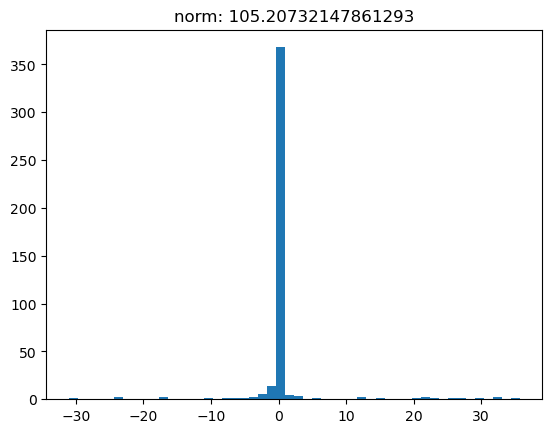

In [7]:
dmis1_rto = data_misfit.L1DataMisfit(simulation=simulation, data=data_object)
r = dmis1_rto.residual(np.vstack(results).mean(axis=0))
plt.hist(r, 50)
plt.title(f'norm: {np.linalg.norm(r)}')


In [14]:
# weighted_diff = dmis1_rto.W.diagonal() * r

# mask = weighted_diff <=  1.0

# print(mask.shape)
dmis1_rto.deriv(np.vstack(results).mean(axis=0))

KeyboardInterrupt: 

In [38]:
import numpy as np

class L1HuberLossObjective:
    def __init__(self, W, F):
        self.W = np.diag(W)  # Convert weights to a diagonal matrix
        self.F = F
    
    def evaluate(self, m, D):
        predicted = self.F(m)
        diff = predicted - D
        weighted_diff = np.dot(self.W, diff)
        
        delta = 1.0
        abs_diff = np.abs(weighted_diff)
        mask = abs_diff <= delta
        
        # Huber loss computation
        loss = np.sum(np.where(mask, 0.5 * abs_diff ** 2, delta * (abs_diff - 0.5 * delta)))
        
        return loss
    
    def gradient(self, m, D, epsilon=1e-6):
        grad = np.zeros_like(m)
        for i in range(len(m)):
            m_plus_eps = m.copy()
            m_plus_eps[i] += epsilon
            loss_plus_eps = self.evaluate(m_plus_eps, D)
            
            m_minus_eps = m.copy()
            m_minus_eps[i] -= epsilon
            loss_minus_eps = self.evaluate(m_minus_eps, D)
            
            grad[i] = (loss_plus_eps - loss_minus_eps) / (2 * epsilon)
        
        return grad
    
    def second_derivative(self, m, D, epsilon=1e-6):
        hess = np.zeros((len(m), len(m)))
        for i in range(len(m)):
            for j in range(len(m)):
                m_plus_plus = m.copy()
                m_plus_plus[i] += epsilon
                m_plus_plus[j] += epsilon
                loss_plus_plus = self.evaluate(m_plus_plus, D)
                
                m_plus_minus = m.copy()
                m_plus_minus[i] += epsilon
                m_plus_minus[j] -= epsilon
                loss_plus_minus = self.evaluate(m_plus_minus, D)
                
                m_minus_plus = m.copy()
                m_minus_plus[i] -= epsilon
                m_minus_plus[j] += epsilon
                loss_minus_plus = self.evaluate(m_minus_plus, D)
                
                m_minus_minus = m.copy()
                m_minus_minus[i] -= epsilon
                m_minus_minus[j] -= epsilon
                loss_minus_minus = self.evaluate(m_minus_minus, D)
                
                hess[i][j] = (loss_plus_plus - loss_plus_minus - loss_minus_plus + loss_minus_minus) / (4 * epsilon ** 2)
        
        return hess

# Example usage:
# Define function F (you'd need to define this function)
def F(m):
    # Example function, you should replace this with your own
    return np.dot(m, np.array([2, 3, 4]))  # Example predicted data calculation

# Define weights W as a vector
weights = [2, 3, 4]  # Example weights

# Define observed data D as a vector
observed_data = np.array([5, 7, 9])  # Example observed data

# Create an instance of the L1HuberLossObjective class
l1_huber_obj = L1HuberLossObjective(W=weights, F=F)

# Evaluate the loss at a specific value of m and observed data D
m_value = np.array([1.5, 2.0, 3.0])  # Example m value
loss_result = l1_huber_obj.evaluate(m_value, observed_data)
print("Loss at m =", m_value, ":", loss_result)

# Calculate the gradient at a specific value of m and observed data D
gradient_result = l1_huber_obj.gradient(m_value, observed_data)
print("Gradient at m =", m_value, ":", gradient_result)

# Calculate the second derivatives at a specific value of m and observed data D
second_derivative_result = l1_huber_obj.second_derivative(m_value, observed_data)
print("Hessian at m =", m_value, ":", second_derivative_result)


Loss at m = [1.5 2.  3. ] : 120.5
Gradient at m = [1.5 2.  3. ] : [18.00000001 26.99999999 36.00000001]
Hessian at m = [1.5 2.  3. ] : [[ 0.         -0.01065814  0.        ]
 [-0.01065814  0.          0.        ]
 [ 0.          0.          0.        ]]


# Dipping rto-be

In [170]:
rto_dip = np.load('../rto_models_2d_dip_test_l2p2.npy')


  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_146906/2974248904.py:42: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/tmp/ipykernel_146906/2974248904.py:61: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_146906/2974248904.py:66: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(np.vstack(results).mean(axis=0)),clim=[0, 500], ax=ax[1], pcolorOpts={'cmap':"Spectral"})
/tmp/ipykernel_146906/2974248904.py:79: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat2 = mes

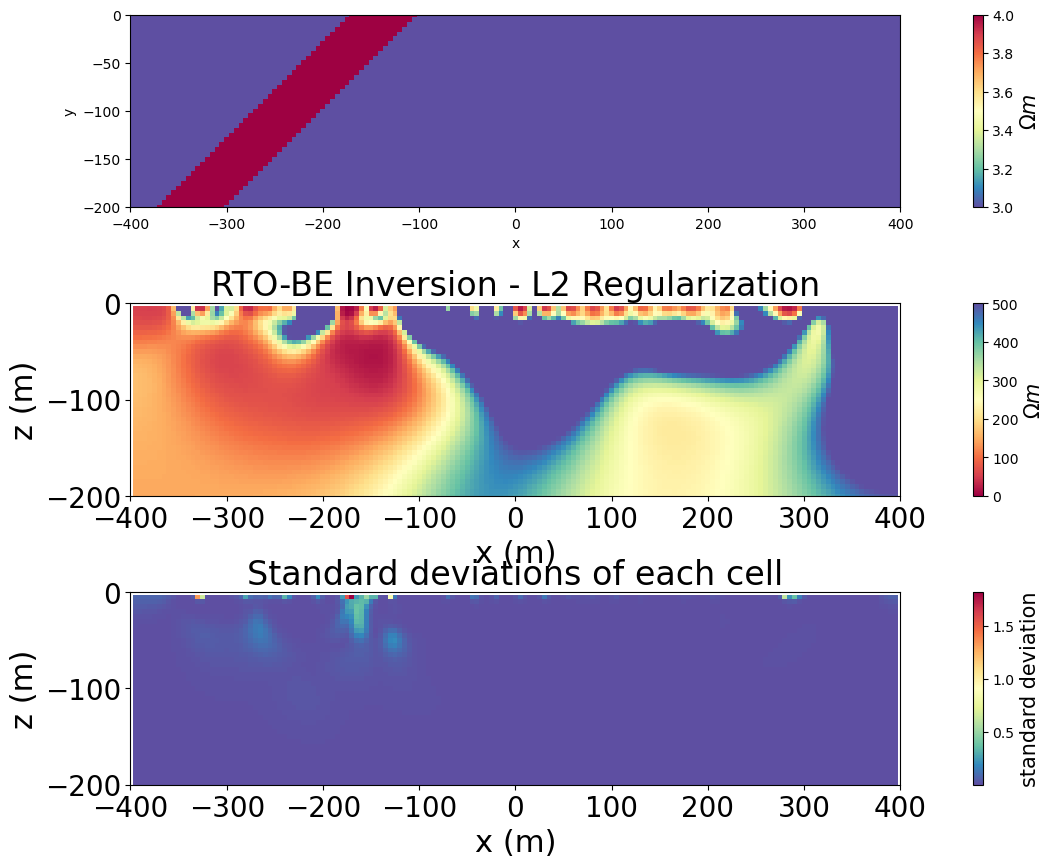

In [171]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 45*
dike0 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 100)
dike1 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 175)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(20,10))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
ax[0].set_xlim([-400, 400])
ax[0].set_ylim([-200, 0])
ax[0].set_aspect('equal')
plt.colorbar(mm1[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')

# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500.0
res_true[model==4]= 10.0

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# fig, ax = plt.subplots(2,1,figsize=(15,10))
results = rto_dip
dat = meshCore.plotImage(1 / np.exp(np.vstack(results).mean(axis=0)),clim=[0, 500], ax=ax[1], pcolorOpts={'cmap':"Spectral"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[1].set_title('RTO-BE Inversion - L2 Regularization',fontsize=24)
ax[1].set_xlim([-400, 400])
ax[1].set_ylim([-200, 0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
ax[1].set_aspect('equal')
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')

std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
dat2 = meshCore.plotImage(std_plot_model, ax=ax[2], pcolorOpts={'cmap':"Spectral_r"})
# dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(models2)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.3})
ax[2].set_title('Standard deviations of each cell',fontsize=24)
ax[2].set_xlim([-400, 400])
ax[2].set_ylim([-200, 0])
ax[2].set_xlabel('x (m)',fontsize=22)
ax[2].set_ylabel('z (m)',fontsize=22)
ax[2].tick_params(labelsize=20)
ax[2].set_aspect('equal')
plt.colorbar(dat2[0]).set_label(label=r'standard deviation',size=15)

fig.subplots_adjust(right=0.85, hspace=0.5)
